# Data Exploration: Amazon Reviews

In [ ]:
using DataFrames
using Arrow
using Printf
using StatsBase: mean, sample, percentile
using Random
using Revise
using Plots
using Unicode

In [ ]:
using TokenizersLite

## Load data

In [ ]:
path = "path\\to\\amazon_reviews_multi\\en\\1.0.0\\"
file_train = "amazon_reviews_multi-train.arrow"
file_test = "amazon_reviews_multi-test.arrow" ;

In [ ]:
checksum = readdir(path)[1]
filepath = joinpath(path, checksum, file_train)
df = DataFrame(Arrow.Table(filepath))

checksum = readdir(path)[1]
filepath = joinpath(path, checksum, file_test)
df_test = DataFrame(Arrow.Table(filepath));

In [ ]:
nrow(df)

200000

## Tokenizers

In [ ]:
pattern = r"[A-Za-z][A-Za-z]+\b"

r"[A-Za-z][A-Za-z]+\b"

In [ ]:
function clean(s::AbstractString)
    s = lowercase(s)
    s = Unicode.normalize(s, :NFD)
    s = replace(s, r"['`’\u200d\p{M}]" => "") # contractions, zero width joiner and marks from normalization
    s = replace(s, r"\n" => " ")
end

function preprocess(document; pattern = r"[A-Za-z][A-Za-z]+\b", max_length::Union{Nothing, Int}=nothing)
    document = clean(document)
    words = map(m->string(m.match), eachmatch(pattern, document))
    words
end

preprocess (generic function with 1 method)

In [ ]:
directory = "../vocab\\bpe"
path_rules = joinpath(directory, "amazon_reviews_train_en_rules.txt")
bpe = load_bpe(path_rules, startsym="⋅")

BytePairEncoder{String}(length(rules)=8000, length(cache)=0, unksym=[UNK], startsym=⋅, symbols=["##a", "##b", "##c", "##d", "##e", "##f", "##g", "##h", "##i", "##j", "##k", "##l", "##m", "##n", "##o", "##p", "##q", "##r", "##s", "##t", "##u", "##v", "##w", "##x", "##y", "##z", "⋅a", "⋅b", "⋅c", "⋅d", "⋅e", "⋅f", "⋅g", "⋅h", "⋅i", "⋅j", "⋅k", "⋅l", "⋅m", "⋅n", "⋅o", "⋅p", "⋅q", "⋅r", "⋅s", "⋅t", "⋅u", "⋅v", "⋅w", "⋅x", "⋅y", "⋅z", ",", ".", "?", "!", ":", ";", "\$", "€", "£", "&"])

In [ ]:
directory = "../vocab\\affixes"
path_vocab = joinpath(directory, "amazon_reviews_train_en_vocab.txt")
affixer = load_affix_tokenizer(path_vocab)

AffixTokenizer(length(vocab)=7179, prefixes=["un", "in"], suffixes=["s", "ed", "ing", "ly", "er", "es", "ers", "al", "ally", "ion", "en", "able", "ably", "less", "ies", "ation", "ty", "est", "ier", "ive", "ment", "ity", "ness", "ful", "or", "age", "ie", "ish", "ible", "ery", "ingly", "ant", "ical", "ance", "ative", "ous", "ties", "ary", "ist", "ated", "ial", "hood", "ify", "itive", "ition", "ise", "eous", "tion", "ious", "ate"])

In [ ]:
sentence_splitter = RuleBasedSentenceSplitter()

RuleBasedSentenceSplitter(non_breaking_prefixes=Set(["Z", "C", "P", "Jul", "Eg", "Dec", "Sen", "Rev", "Mar", "BComm"  …  "E", "I", "J", "Snr", "eg", "Fri", "R", "Ms", "MBA", "Nov"]), non_breaking_numeric_prefixes=Set(["nr", "No", "pg", "Nr", "no", "p"]))

In [ ]:
idx = 100
println(idx)
document = df[idx, "review_body"]
println(document)
words = preprocess(document, pattern=pattern)
println(join(words, "|"))
tokens = bpe(words)
println(join(tokens, "|"))
tokens = affixer(words)
println(join(tokens, "|"))

100
I bought these bottles with the intention of mixing essential oils in them. The spray hardly works and they leak frequently. Would not recommend for use with essential oils.
bought|these|bottles|with|the|intention|of|mixing|essential|oils|in|them|the|spray|hardly|works|and|they|leak|frequently|would|not|recommend|for|use|with|essential|oils
⋅bought|⋅these|⋅bottles|⋅with|⋅the|⋅intent|##ion|⋅of|⋅mixing|⋅essential|⋅oils|⋅in|⋅them|⋅the|⋅spray|⋅hardly|⋅works|⋅and|⋅they|⋅leak|⋅frequently|⋅would|⋅not|⋅recommend|⋅for|⋅use|⋅with|⋅essential|⋅oils
bought|these|bottle|-s|with|the|intention|of|mix|-ing|essential|oil|-s|in|them|the|spray|hard|-ly|work|-s|and|they|leak|frequent|-ly|would|not|recommend|for|use|with|essential|oil|-s


## Data exploration

In [ ]:
names(df)

8-element Vector{String}:
 "review_id"
 "product_id"
 "reviewer_id"
 "stars"
 "review_body"
 "review_title"
 "language"
 "product_category"

In [ ]:
first(df, 5)

,review_id,product_id,reviewer_id,stars,review_body
,String?,String?,String?,Int32?,String?
1,en_0964290,product_en_0740675,reviewer_en_0342986,1,"Arrived broken. Manufacturer defect. Two of the legs of the base were not completely formed, so there was no way to insert the casters. I unpackaged the entire chair and hardware before noticing this. So, I'll spend twice the amount of time boxing up the whole useless thing and send it back with a 1-star review of part of a chair I never got to sit in. I will go so far as to include a picture of what their injection molding and quality assurance process missed though. I will be hesitant to buy again. It makes me wonder if there aren't missing structures and supports that don't impede the assembly process."
2,en_0690095,product_en_0440378,reviewer_en_0133349,1,the cabinet dot were all detached from backing... got me
3,en_0311558,product_en_0399702,reviewer_en_0152034,1,I received my first order of this product and it was broke so I ordered it again. The second one was broke in more places than the first. I can't blame the shipping process as it's shrink wrapped and boxed.
4,en_0044972,product_en_0444063,reviewer_en_0656967,1,"This product is a piece of shit. Do not buy. Doesn't work, and then I try to call for customer support, it won't take my number. Fucking rip off!"
5,en_0784379,product_en_0139353,reviewer_en_0757638,1,went through 3 in one day doesn't fit correct and couldn't get bubbles out (better without)


In [ ]:
labels = df[:, "stars"];

In [ ]:
n = length(labels)
nshow = 2
for stars in 1:5
    println(stars)
    idxs  = (1:n)[labels .== stars] 
    for idx in sample(idxs, nshow)
        println("$(idx): ", df[idx, "review_body"])
    end
end

1
19095: Triggered my asthma really badly and kept it going for at least 30 minutes after getting out of the bath. Asthma attack didn't respond to emergency inhalers. Happened both times that I tried to use this product. Baths without using this caused no asthma attack, so I'm pretty sure it's not the water. I don't know if my body is just really screwed up or what, but I would urge you to be on guard if anybody reading this has asthma and wants to try this. Not sure if it did anything for my eczema but two uses don't seem it'd be enough to make a difference.
20177: These things are so cheaply made. A few were broken in the packaging when we opened them and others broke after being lightly handled. Definitely not worth over $1 a piece.
2
73026: Does not really fit my sons face and the band that goes around his head is constantly slipping off.
41021: Hard time picking up Wii remotes. Very off with the actual movement of the remotes
3
114115: I like the item , I thought two gloves would 

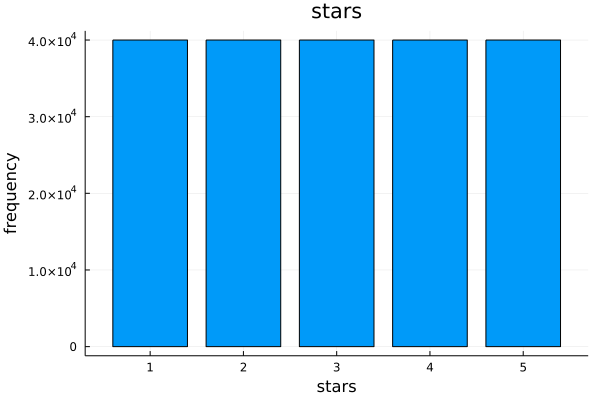

In [ ]:
x = 1:5
y = [sum(labels .== l) for l in x]
bar(x, y, xlabel="stars", ylabel="frequency", title="stars", label="")

In [ ]:
languages = unique(df[:, :language])

1-element Vector{Union{Missing, String}}:
 "en"

In [ ]:
products = unique(df[!, :product_category])

31-element Vector{Union{Missing, String}}:
 "furniture"
 "home_improvement"
 "home"
 "wireless"
 "pc"
 "industrial_supplies"
 "kitchen"
 "apparel"
 "automotive"
 "camera"
 "lawn_and_garden"
 "watch"
 "beauty"
 ⋮
 "jewelry"
 "sports"
 "other"
 "baby_product"
 "video_games"
 "office_product"
 "grocery"
 "digital_video_download"
 "luggage"
 "shoes"
 "musical_instruments"
 "personal_care_appliances"

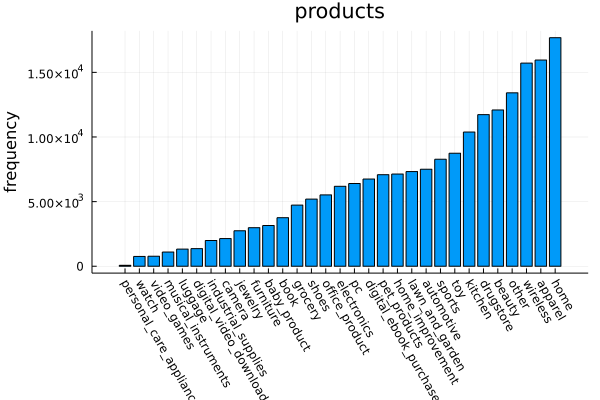

In [ ]:
x = 1:length(products)
y = [sum(df[!, :product_category] .== p) for p in products]
idxs = sortperm(y)
bar(x, y[idxs], 
    title="products", xlabel="product categories", ylabel="frequency", label="", 
    xrotation=-60, xticks=(x, products[idxs])
)

### Content lengths

In [ ]:
@time transform!(df, :review_body =>  ByRow(s -> length(s)) => :review_length);
@time transform!(df, :review_body =>  ByRow(s -> length(findall(pattern, s))) => :review_word_count);
@time transform!(df, :review_body =>  ByRow(s -> length(sentence_splitter(s))) => :review_sentence_count);

@time transform!(df, :review_title =>  ByRow(s -> length(s)) => :review_title_length);
@time transform!(df, :review_title =>  ByRow(s -> length(findall(pattern, s))) => :review_title_word_count);
@time transform!(df, :review_title =>  ByRow(s -> length(sentence_splitter(s))) => :review_title_sentence_count);

  0.972791 seconds (2.06 M allocations: 148.042 MiB, 6.26% gc time, 94.54% compilation time)
  1.582987 seconds (1.15 M allocations: 355.188 MiB, 4.51% gc time, 8.71% compilation time)
 10.052779 seconds (90.83 M allocations: 5.276 GiB, 11.41% gc time, 1.78% compilation time)
  0.165571 seconds (315.19 k allocations: 16.678 MiB, 51.26% compilation time)
  0.362795 seconds (757.00 k allocations: 71.167 MiB, 5.88% gc time, 25.30% compilation time)
  1.554959 seconds (11.77 M allocations: 588.526 MiB, 8.33% gc time, 6.12% compilation time)


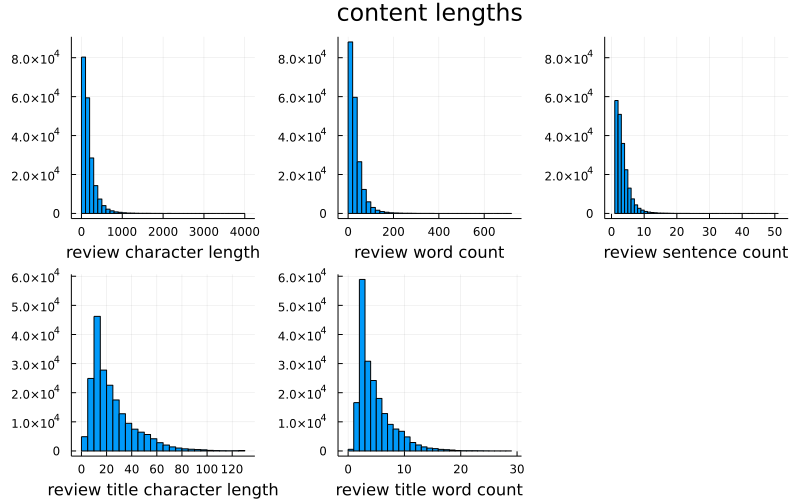

In [ ]:
p11 = histogram(df[!, :review_length], nbins=50, label="", xlabel="review character length")
p12 = histogram(df[!, :review_word_count], nbins=50,  label="", xlabel="review word count")
p13 = histogram(df[!, :review_sentence_count], nbins=50,  label="", xlabel="review sentence count")

p21 = histogram(df[!, :review_title_length], nbins=50, label="", xlabel="review title character length")
p22 = histogram(df[!, :review_title_word_count], nbins=50,  label="", xlabel="review title word count")
p23 = plot(grid=false, axis=false, ticks=false)
plot(p11, p12, p13, 
     p21, p22, p23,
    layout=grid(2, 3), 
    link=:y, plot_title="content lengths", size=(800, 500))

In [ ]:
function encode_bpe(document)
    bpe(preprocess(document, pattern=pattern))
end
function encode_affixer(document)
    affixer(preprocess(document, pattern=pattern))
end
@time transform!(df, :review_body =>  ByRow(s -> length(encode_bpe(s))) => :bpe_length); # takes about 30 seconds
@time transform!(df, :review_body =>  ByRow(s -> length(encode_affixer(s))) => :affixer_length); # takes about 10 seconds

 56.695405 seconds (654.47 M allocations: 20.559 GiB, 8.56% gc time, 0.62% compilation time)
 14.432648 seconds (140.26 M allocations: 5.529 GiB, 6.61% gc time, 1.01% compilation time)


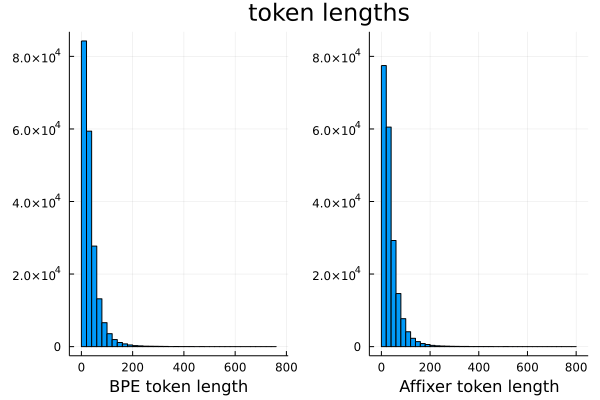

In [ ]:
p1 = histogram(df[!, :bpe_length], nbins=50, label="", xlabel="BPE token length")
p2 = histogram(df[!, :affixer_length], nbins=50,  label="", xlabel="Affixer token length")
plot(p1, p2, labyout=grid(1, 2), link=:y, plot_title="token lengths")

In [ ]:
for metric in [:review_sentence_count, :review_word_count, :bpe_length, :affixer_length]
    println(metric)
    @printf "mean: %.2f\n" mean(df[:, metric])
    for p in [25, 50, 75, 95, 99, 100] 
        threshold = percentile(df[:, metric], p)
        @printf "%3d%% - %3d\n" p threshold
    end
    println("")
end

review_sentence_count
mean: 2.90
 25% -   1
 50% -   2
 75% -   4
 95% -   7
 99% -  11
100% -  50

review_word_count
mean: 31.84
 25% -  12
 50% -  22
 75% -  41
 95% -  89
 99% - 154
100% - 713

bpe_length
mean: 33.61
 25% -  12
 50% -  23
 75% -  43
 95% -  95
 99% - 165
100% - 753

affixer_length
mean: 36.11
 25% -  13
 50% -  25
 75% -  46
 95% - 101
 99% - 175
100% - 788



## Content lengths (sentences)

In [ ]:
max_val, idx = findmax(df[:, :review_sentence_count])
for (i, s) in enumerate(sentence_splitter(df[idx, :review_body]))
    println(i, " ", s)
end

1 Alright.
2 Third case for my new Note 8.
3 The first one I ordered offered NO protection.
4 The second one had AWESOME protection and looked great but the buttons were heck to push and the stylus wouldn't come out.
5 THIS GUY: Looks great.
6 I bought the gold case.
7 I'm not generally a gold person.
8 I'm fairly safe and go with black usually.
9 But I took a risk and I'm glad I did.
10 Super sharp.
11 For men AND women.
12 Not shiny or sparkly.
13 Just a metallic/sharp style.
14 Although it's a hard case, it DOES have slight cushion.
15 I'm fairly darn certain my phone will survive if I drop it.
16 My biggest worry and stress for purchasing a case is dropping my precious buddy.
17 I'm not as certain with this case as I've been with other cases, however.
18 The Note 8 has a curved screen, which I'm not a fan of.
19 I think it's gimmicky and prefer practical over presence.
20 This case does not wrap around the curves.
21 They are exposed.
22 IF you drop your phone just right and it hap

In [ ]:
sentence_lengths = Int64[]
longest_sentence = ""
longest_sentence_count = 0
all_sentences = String[]
for row in eachrow(df)
    text = row[:review_body]
    sentences = sentence_splitter(text)
    push!(all_sentences, sentences...)
    for s in sentences
        words = findall(pattern, s)
        push!(sentence_lengths, length(words))
        if length(words) > longest_sentence_count
            longest_sentence_count = length(words)
            longest_sentence = s
        end
    end
end

In [ ]:
print(longest_sentence_count, " " , longest_sentence)

211 Great book to know about the learning of accelerate and great book on getting the hang of, planning for learning, and making a decent mental and physical condition for essentially what is fulfilling your objectives and as the creator notes, learning is the thing that opens your life, however it won't not be what gets you there and that is alright and book has many very good thoughts provoking and eye-opening points and there are so many books out there but this one is worth each penny and this book is easy to follow and can be applied almost immediately and the summary behind each chapter provides a quick reference guide to the detail involved and if you wish to learn or teach others to learn faster and don't have much time to read and this book is for you and the author pointed out some of the most practical terms and aspects how we can understand our memory working procedure as the way we needed to increase the skills and most importantly although the author writes this book from

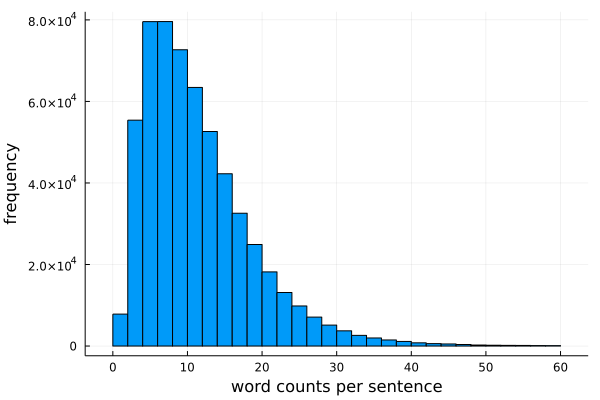

In [ ]:
histogram(sentence_lengths[sentence_lengths .< 60], 
    nbins=50,  
    label="", xlabel="word counts per sentence", 
    ylabel="frequency")

In [ ]:
@show mean(sentence_lengths)
for p in [25, 50, 75, 95, 99, 100] 
    threshold = percentile(sentence_lengths, p)
    @printf "%3d%% - %4d\n" p threshold
end

mean(sentence_lengths) = 10.996912082427366
 25% -    6
 50% -    9
 75% -   15
 95% -   25
 99% -   36
100% -  211
